In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Monthly Air Passengers from January 1949 to December 1960
df = pd.read_csv('../data/air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#### 8.3.2 Forecasting with a SARIMA(p,d,q)(P,D,Q)_m model

In [3]:
# Pg 172

ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060441
p-value: 0.9918802434376409


In [4]:
df['Passengers'].tail() #$hape (144,)

139    606
140    508
141    461
142    390
143    432
Name: Passengers, dtype: int64

In [5]:
# Pg 172

df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241699968
p-value: 0.05421329028382589


In [6]:
df_diff

array([   6,   14,   -3,   -8,   14,   13,    0,  -12,  -17,  -15,   14,
         -3,   11,   15,   -6,  -10,   24,   21,    0,  -12,  -25,  -19,
         26,    5,    5,   28,  -15,    9,    6,   21,    0,  -15,  -22,
        -16,   20,    5,    9,   13,  -12,    2,   35,   12,   12,  -33,
        -18,  -19,   22,    2,    0,   40,   -1,   -6,   14,   21,    8,
        -35,  -26,  -31,   21,    3,  -16,   47,   -8,    7,   30,   38,
         -9,  -34,  -30,  -26,   26,   13,   -9,   34,    2,    1,   45,
         49,  -17,  -35,  -38,  -37,   41,    6,   -7,   40,   -4,    5,
         56,   39,   -8,  -50,  -49,  -35,   35,    9,  -14,   55,   -8,
          7,   67,   43,    2,  -63,  -57,  -42,   31,    4,  -22,   44,
        -14,   15,   72,   56,   14, -101,  -45,  -49,   27,   23,  -18,
         64,  -10,   24,   52,   76,   11,  -96,  -56,  -45,   43,   12,
        -26,   28,   42,   11,   63,   87,  -16,  -98,  -47,  -71,   42])

In [7]:
# Pg 172

df_diff_diff = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.38423154246854
p-value: 2.7328918500140445e-29


In [8]:
df_diff_diff

array([   8,  -17,   -5,   22,   -1,  -13,  -12,   -5,    2,   29,  -17,
         14,    4,  -21,   -4,   34,   -3,  -21,  -12,  -13,    6,   45,
        -21,    0,   23,  -43,   24,   -3,   15,  -21,  -15,   -7,    6,
         36,  -15,    4,    4,  -25,   14,   33,  -23,    0,  -45,   15,
         -1,   41,  -20,   -2,   40,  -41,   -5,   20,    7,  -13,  -43,
          9,   -5,   52,  -18,  -19,   63,  -55,   15,   23,    8,  -47,
        -25,    4,    4,   52,  -13,  -22,   43,  -32,   -1,   44,    4,
        -66,  -18,   -3,    1,   78,  -35,  -13,   47,  -44,    9,   51,
        -17,  -47,  -42,    1,   14,   70,  -26,  -23,   69,  -63,   15,
         60,  -24,  -41,  -65,    6,   15,   73,  -27,  -26,   66,  -58,
         29,   57,  -16,  -42, -115,   56,   -4,   76,   -4,  -41,   82,
        -74,   34,   28,   24,  -65, -107,   40,   11,   88,  -31,  -38,
         54,   14,  -31,   52,   24, -103,  -82,   51,  -24,  113])

In [9]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
# Pg 174

ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12] # len 132
#test = df['Passengers'][-12:]  # len 12

d = 2
D = 0
s = 12
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)

SARIMA_result_df

  0%|          | 0/2704 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 0, 3, 2)",14.000000
1,"(2, 1, 2, 2)",16.000000
2,"(3, 1, 2, 1)",16.000000
3,"(3, 1, 3, 1)",18.000000
4,"(4, 1, 2, 1)",18.000000
...,...,...
2119,"(5, 0, 0, 0)",1281.732157
2120,"(3, 0, 0, 0)",1300.282335
2121,"(2, 0, 0, 0)",1302.913196
2122,"(1, 0, 0, 0)",1308.152194


SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)  
After 141 minutes (2 hours 21 minutes)  
	    (p,q,P,Q)	AIC  
0	(1, 0, 3, 2)	14.0  
1	(2, 1, 2, 2)	16.0  
2	(3, 1, 2, 1)	16.0    
3	(3, 1, 3, 1)	18.0   
4	(4, 1, 2, 1)	18.0  
5	(1, 3, 2, 2)	18.0   
6	(4, 1, 3, 1)	20.0   
7	(7, 0, 2, 0)	20.0  
8	(3, 1, 3, 2)	20.0   
9	(5, 2, 2, 1)	22.0  
10	(5, 1, 3, 1)	22.0   
11	(5, 5, 1, 0)	24.0   
12	(3, 4, 3, 2)	26.0  
13	(7, 1, 3, 1)	26.0   
14	(7, 1, 2, 3)	28.0   
15	(8, 2, 2, 1)	28.0  
16	(1, 10, 2, 0)	28.0  
17	(6, 6, 0, 2)	30.0  
18	(1, 10, 3, 0)	30.0  
19	(5, 8, 1, 0)	30.0   

***************************************************************************
Pick a Model and analyze residuals

We pick SARIMA(1,2,0)(3,0,2)_12, which has the lowest AIC

In [12]:
SARIMA_model = SARIMAX(train, order=(1,2,0), seasonal_order=(3,0,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(1, 2, 0)x(3, 0, [1, 2], 12)   Log Likelihood                -590.492
Date:                                 Thu, 12 Feb 2026   AIC                           1194.983
Time:                                         18:37:07   BIC                           1215.056
Sample:                                              0   HQIC                          1203.140
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3294      0.138     -2.390      0.017      -0.600      -0

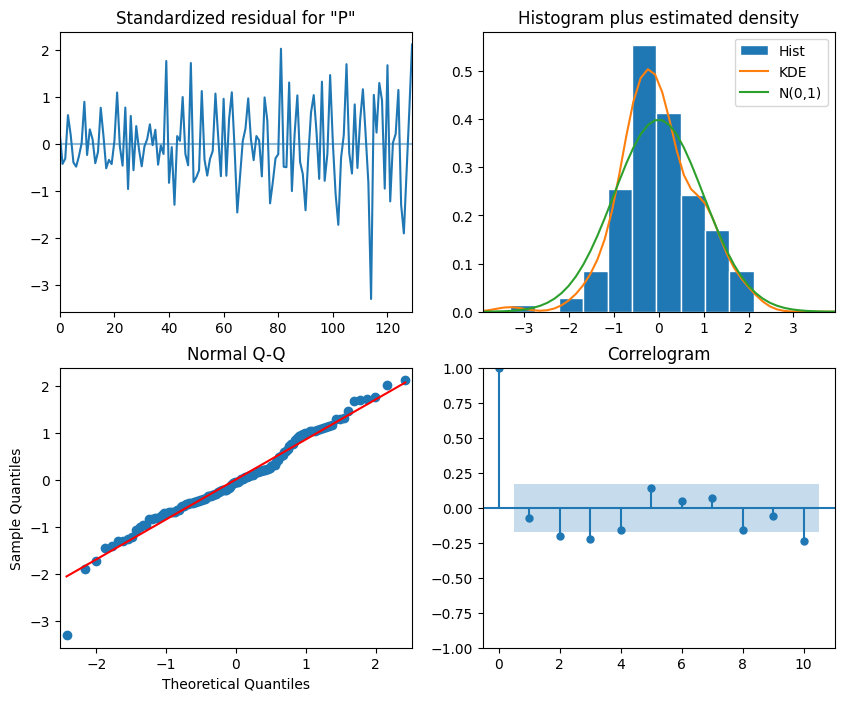

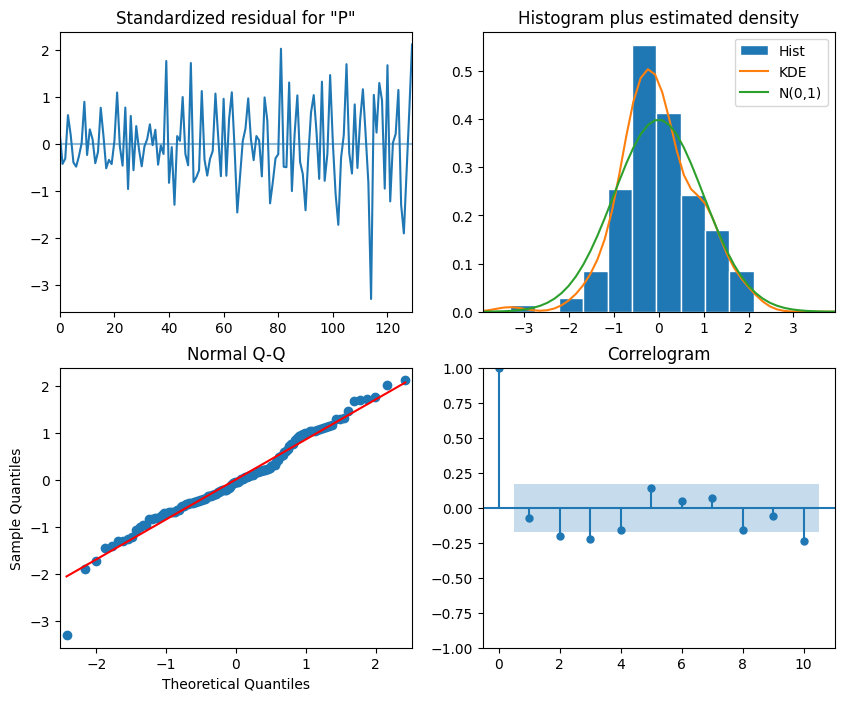

In [13]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [14]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,2.503425,0.113599
2,5.249107,0.072472
3,10.329489,0.015963
4,13.582463,0.008754
5,16.190956,0.006320
6,16.702584,0.010441
7,16.959872,0.017657
8,20.005697,0.010315
9,20.549776,0.014807
10,26.893244,0.002708


SARIMA(1,2,0)(3,0,2)_12, Ljung-Box test we can reject null hypothesis for lags 3 to lag 20  
We pick now SARIMA(3,2,1)(2,0,1)_12

In [53]:
SARIMA_model = SARIMAX(train, order=(3,2,1), seasonal_order=(2,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(3, 2, 1)x(2, 0, 1, 12)   Log Likelihood                -608.947
Date:                            Thu, 12 Feb 2026   AIC                           1233.895
Time:                                    23:20:01   BIC                           1256.835
Sample:                                         0   HQIC                          1243.216
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2191      0.349     -0.627      0.531      -0.904       0.466
ar.L2         -0.4010      0.227   

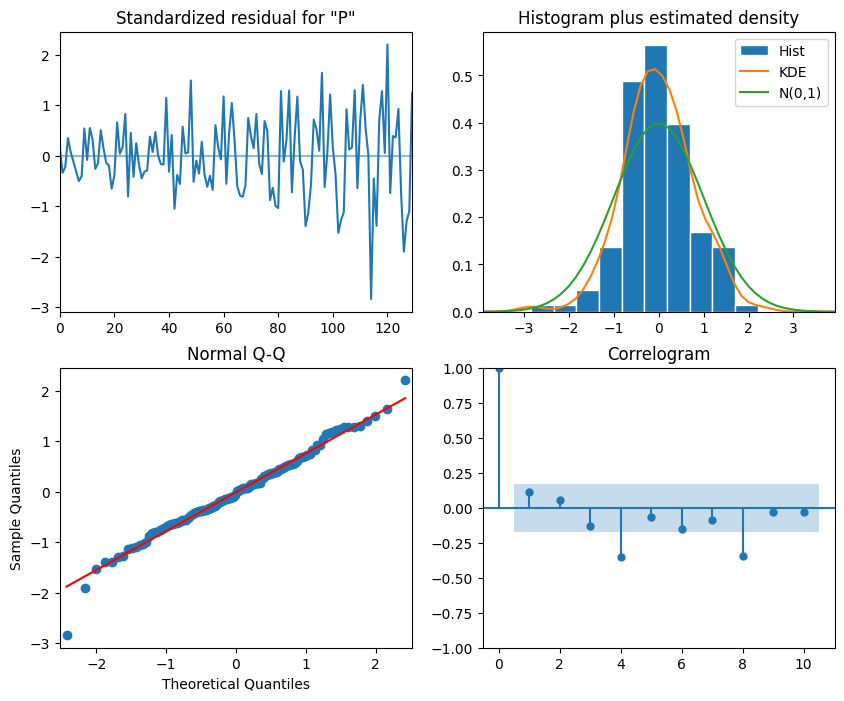

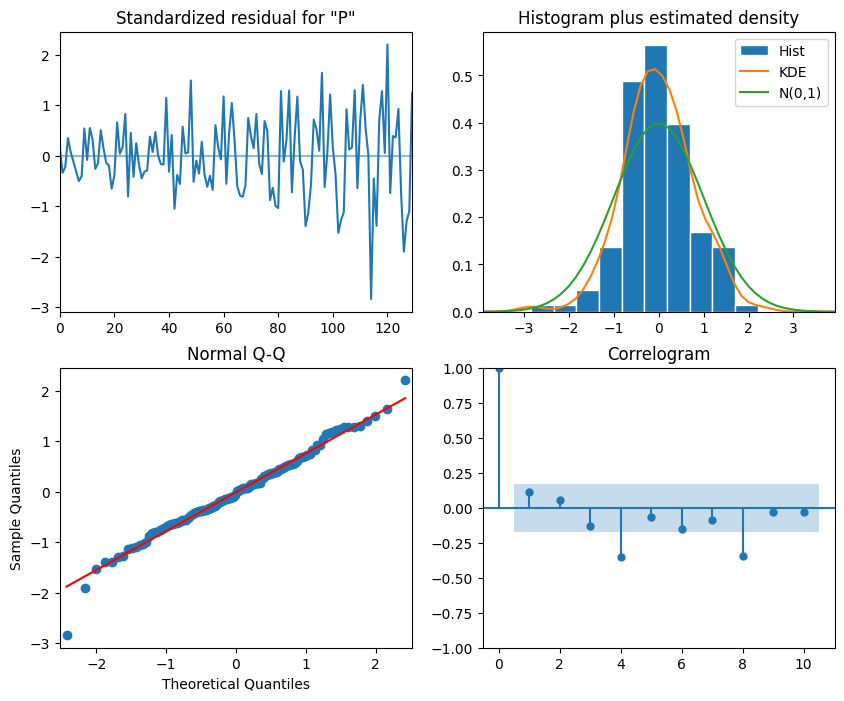

In [54]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [55]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.107889,0.742560
2,0.591577,0.743945
3,2.654708,0.447979
4,15.896866,0.003161
5,16.160652,0.006400
6,18.140650,0.005890
7,18.849339,0.008673
8,30.962555,0.000143
9,31.222708,0.000271
10,31.657392,0.000457


SARIMA(3,2,1)(2,0,1)_12, Ljung-Box test we can reject null hypothesis for lags 4 to lag 20  
We pick now SARIMA(2,2,1)(2,0,2)_12

In [18]:
SARIMA_model = SARIMAX(train, order=(2,2,1), seasonal_order=(2,0,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 2, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -597.811
Date:                                 Thu, 12 Feb 2026   AIC                           1211.622
Time:                                         18:37:10   BIC                           1234.562
Sample:                                              0   HQIC                          1220.943
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4639      0.262      1.769      0.077      -0.050       0

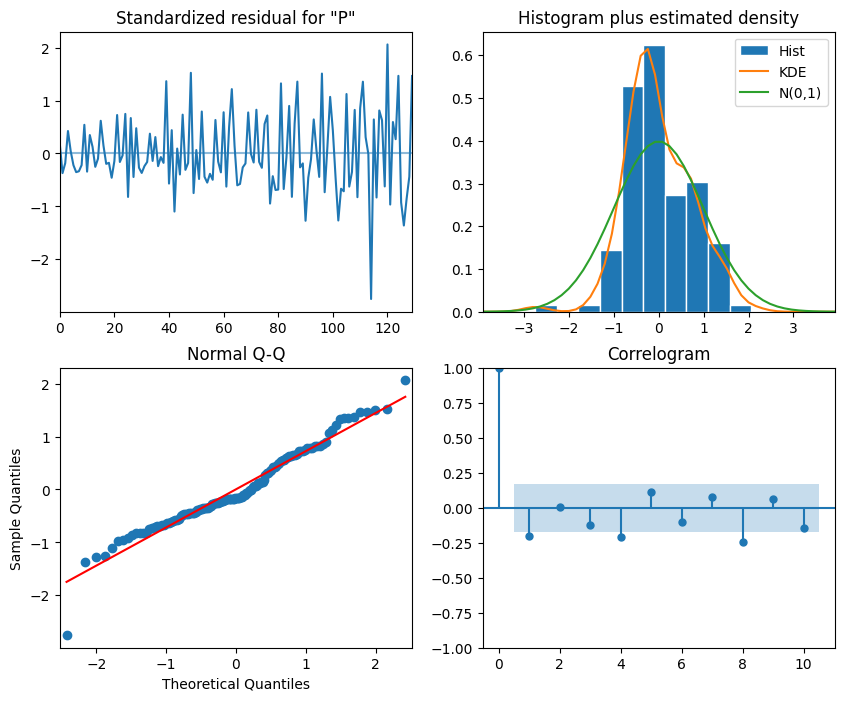

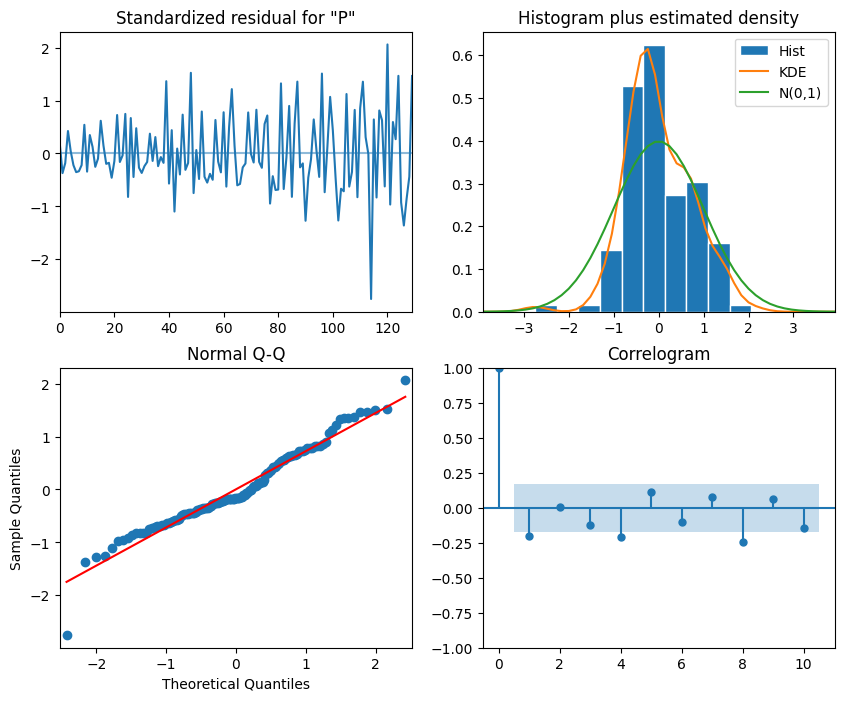

In [19]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [20]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,8.060376,0.004524
2,8.135236,0.017118
3,10.023158,0.018370
4,14.797221,0.005141
5,16.426680,0.005726
6,17.061399,0.009060
7,17.483394,0.014531
8,23.627383,0.002646
9,23.853777,0.004539
10,26.865608,0.002735


SARIMA(2,2,1)(2,0,2)_12, Ljung-Box test we can reject null hypothesis for lags 1 to lag 20  
We pick now SARIMA(1,2,3)(2,0,2)_12	

In [21]:
SARIMA_model = SARIMAX(train, order=(1,2,3), seasonal_order=(2,0,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(1, 2, 3)x(2, 0, [1, 2], 12)   Log Likelihood                -610.162
Date:                                 Thu, 12 Feb 2026   AIC                           1238.325
Time:                                         18:37:12   BIC                           1264.133
Sample:                                              0   HQIC                          1248.811
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5280      1.230     -0.429      0.668      -2.940       1

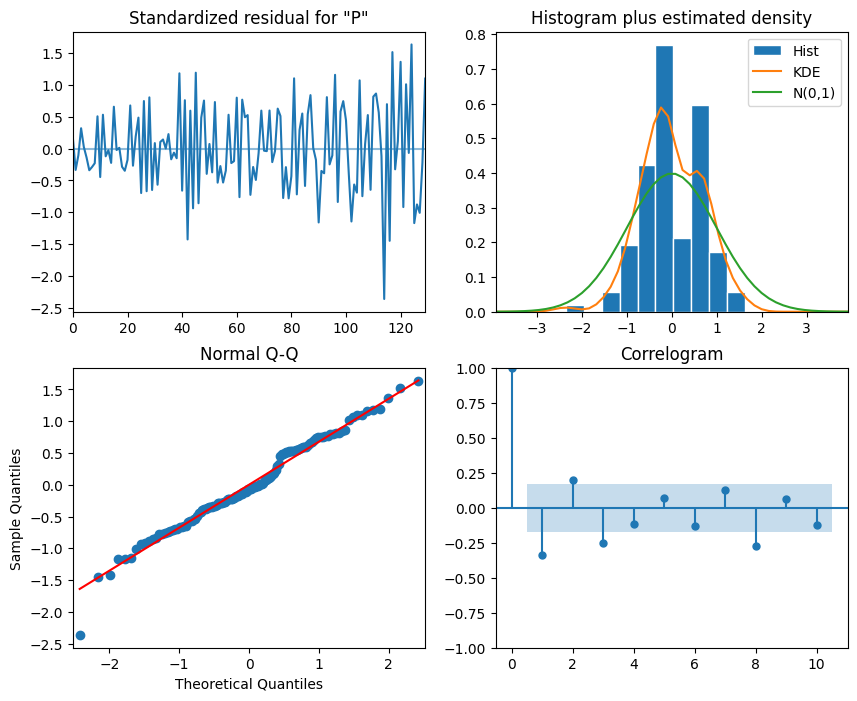

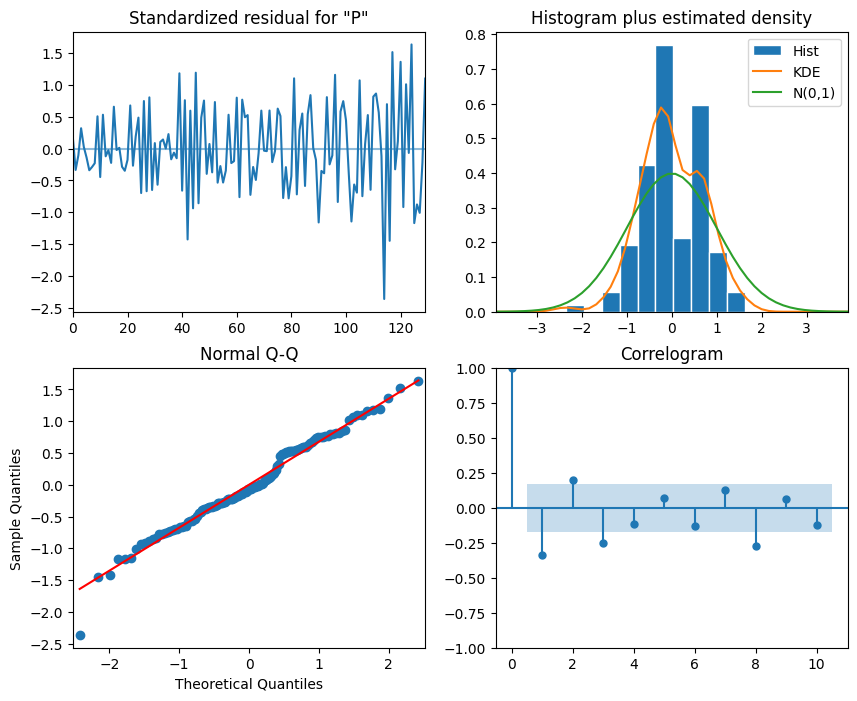

In [22]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [23]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,16.231700,0.000056
2,20.841637,0.000030
3,27.674521,0.000004
4,29.319175,0.000007
5,30.047012,0.000014
6,31.344540,0.000022
7,32.846949,0.000028
8,40.896130,0.000002
9,41.168968,0.000005
10,43.620431,0.000004


SARIMA(1,2,3)(2,0,2)_12	, Ljung-Box test we can reject null hypothesis for lags 1 to lag 20  
We pick now SARIMA(3,2,1)(3,0,1)_12	


In [24]:
SARIMA_model = SARIMAX(train, order=(3,2,1), seasonal_order=(3,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(3, 2, 1)x(3, 0, 1, 12)   Log Likelihood                -624.384
Date:                            Thu, 12 Feb 2026   AIC                           1266.768
Time:                                    18:37:14   BIC                           1292.576
Sample:                                         0   HQIC                          1277.255
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1599      0.564     -0.284      0.777      -1.265       0.945
ar.L2         -0.4119      0.277   

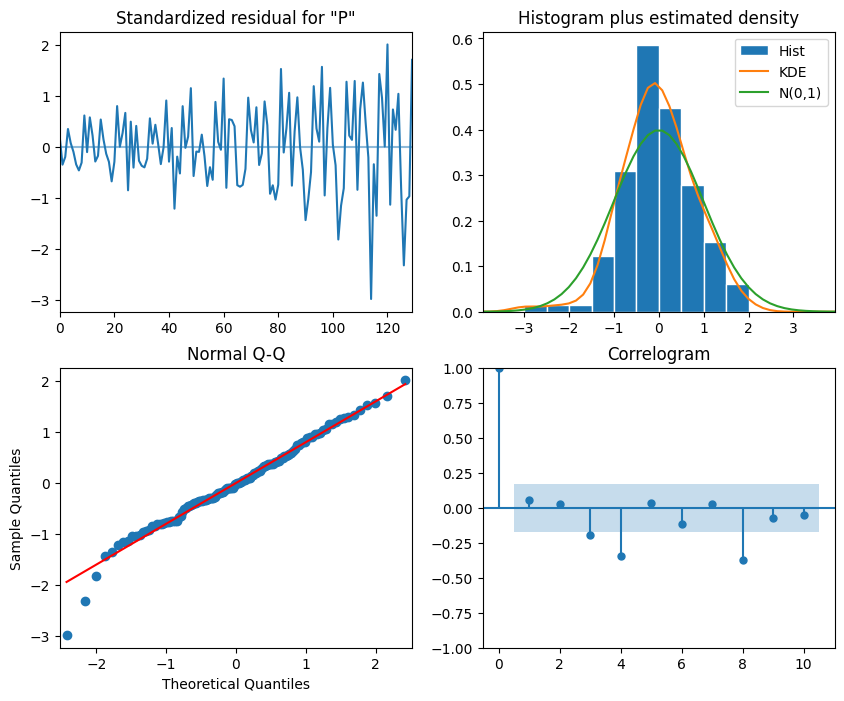

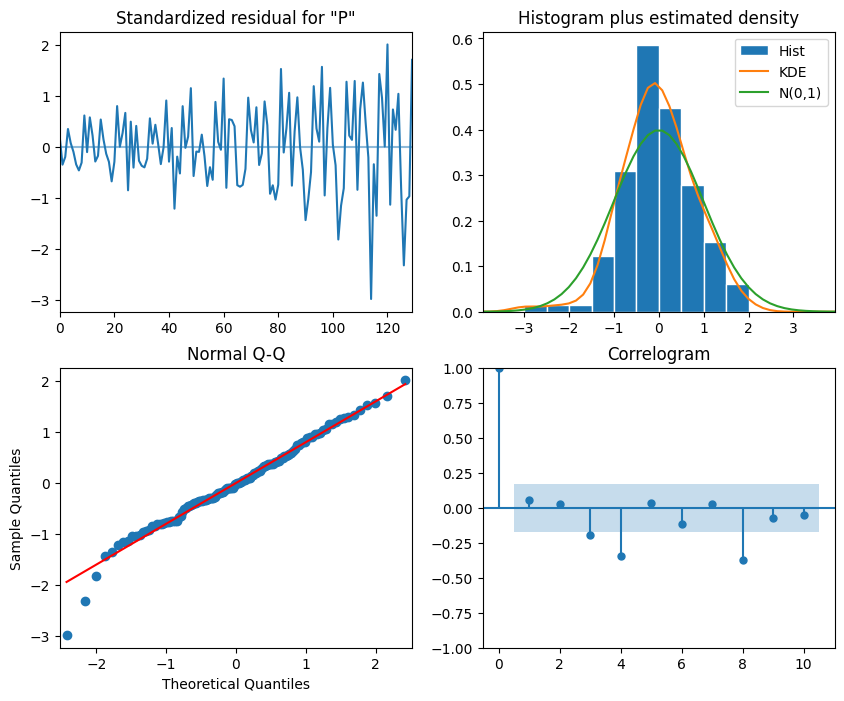

In [25]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [26]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,0.003466,0.953052
2,0.165487,0.920587
3,4.491242,0.213073
4,17.780627,0.001362
5,18.021929,0.002919
6,19.307652,0.003674
7,19.400683,0.007021
8,35.114645,0.000025
9,35.955265,0.000040
10,36.593931,0.000067


SARIMA(3,2,1)(3,0,1)_12	, Ljung-Box test we can reject null hypothesis for lags 4 to lag 20  
We pick now SARIMA(3,2,1)(3,0,2)_12	

In [27]:
SARIMA_model = SARIMAX(train, order=(3,2,1), seasonal_order=(3,0,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(3, 2, 1)x(3, 0, [1, 2], 12)   Log Likelihood                -626.213
Date:                                 Thu, 12 Feb 2026   AIC                           1272.426
Time:                                         18:37:16   BIC                           1301.102
Sample:                                              0   HQIC                          1284.078
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1459      1.385     -0.105      0.916      -2.860       2

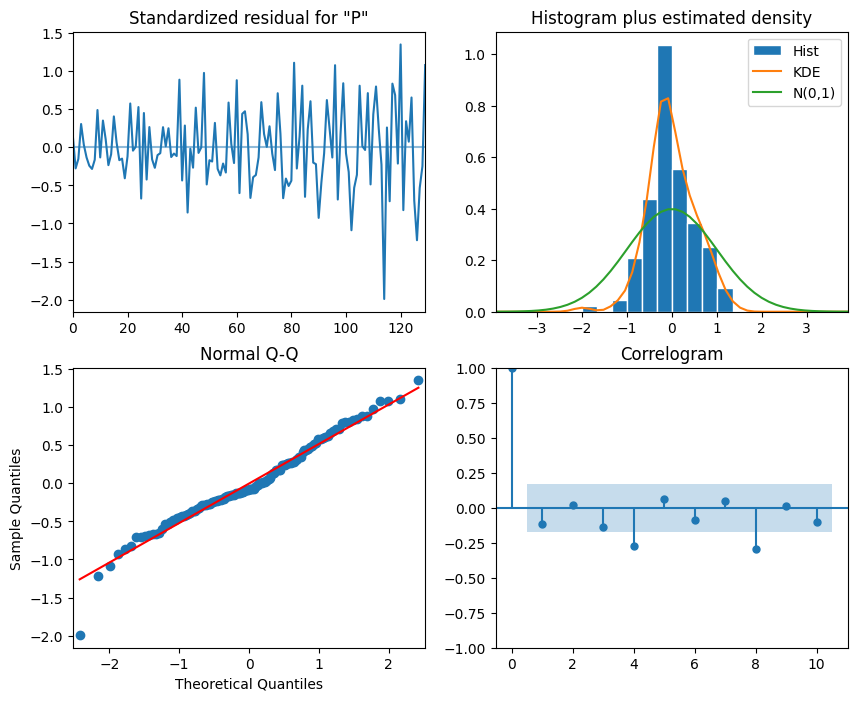

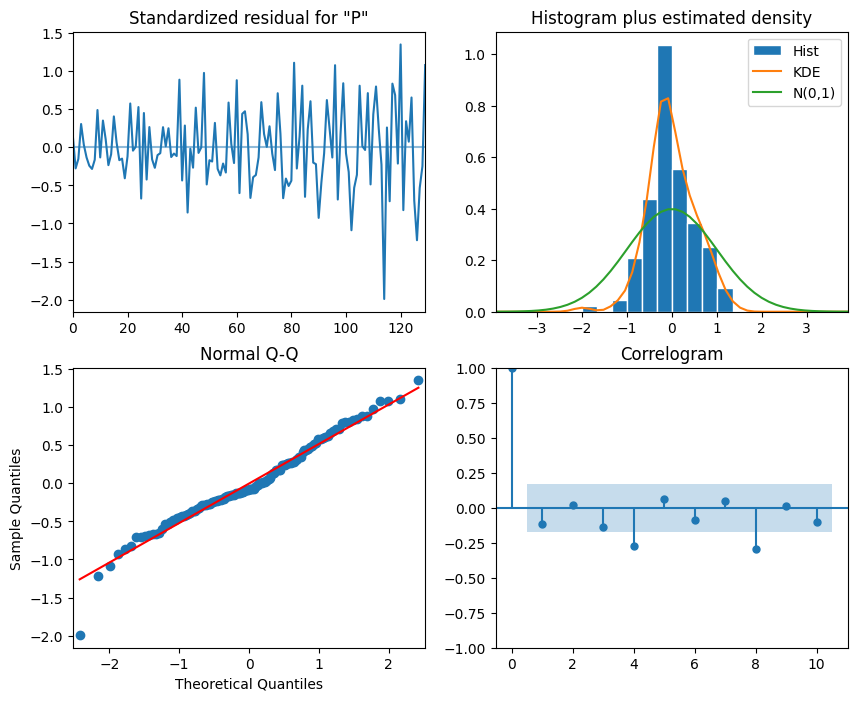

In [28]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [29]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,3.958710,0.046629
2,4.124816,0.127147
3,6.335306,0.096389
4,14.524713,0.005796
5,15.206945,0.009514
6,15.715679,0.015364
7,15.889232,0.026148
8,24.422362,0.001946
9,24.425061,0.003678
10,26.299493,0.003358


SARIMA(3,2,1)(3,0,2)_12	  , Ljung-Box test we can reject null hypothesis for lag and for lags 4 to lag 20   
We pick now SARIMA(1,2,2)(2,0,2)_12 

In [30]:
SARIMA_model = SARIMAX(train, order=(1,2,2), seasonal_order=(2,0,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(1, 2, 2)x(2, 0, 2, 12)   Log Likelihood                -607.229
Date:                            Thu, 12 Feb 2026   AIC                           1230.458
Time:                                    18:37:17   BIC                           1253.399
Sample:                                         0   HQIC                          1239.780
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0238      0.287     -0.083      0.934      -0.586       0.538
ma.L1         -0.3514      0.275   

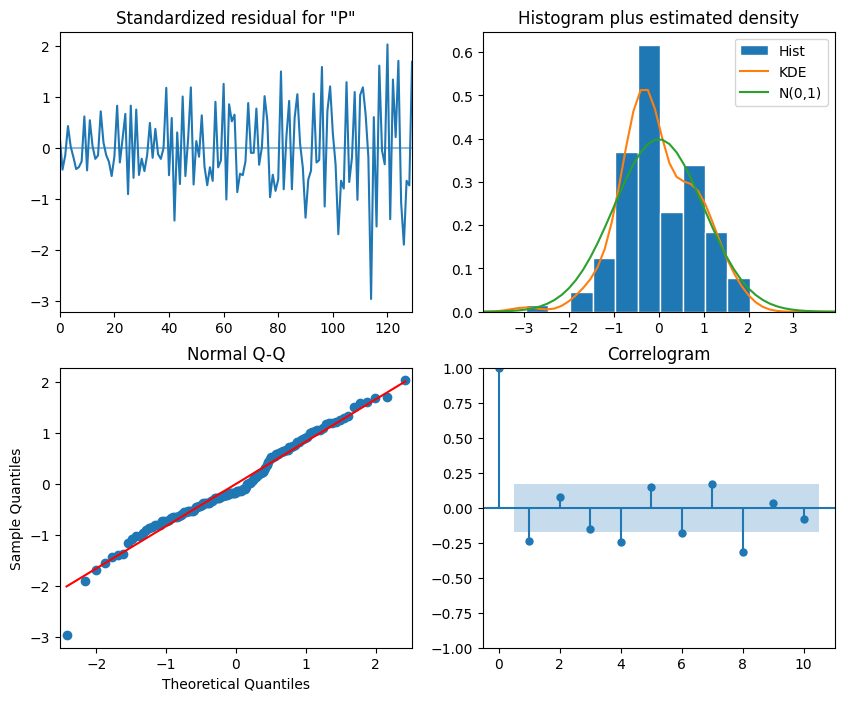

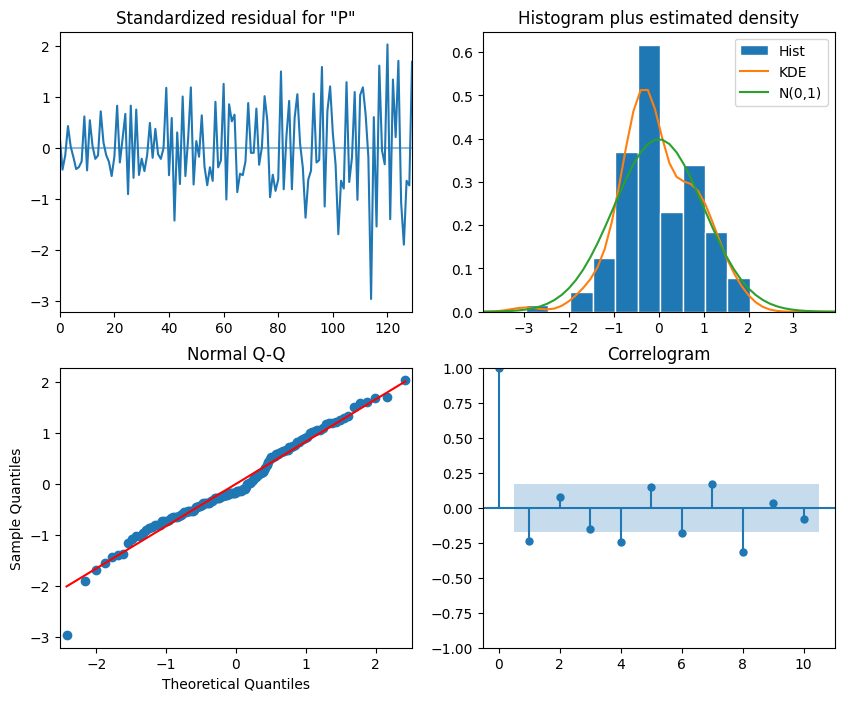

In [31]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [32]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,9.255864,0.002347
2,10.188547,0.006132
3,12.965763,0.004711
4,19.707041,0.000570
5,22.402712,0.000439
6,25.379737,0.000290
7,28.217843,0.000201
8,39.076380,0.000005
9,39.130150,0.000011
10,40.319453,0.000015


SARIMA(1,2,2)(2,0,2)_12 , Ljung-Box test we can reject null hypothesis for lag and for lags 1 to lag 20   
We pick now SARIMA(2,2,0)(2,0,2)_12 

In [33]:
SARIMA_model = SARIMAX(train, order=(2,2,0), seasonal_order=(2,0,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 2, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -610.910
Date:                                 Thu, 12 Feb 2026   AIC                           1235.821
Time:                                         18:37:18   BIC                           1255.893
Sample:                                              0   HQIC                          1243.977
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4314      0.098     -4.407      0.000      -0.623      -0

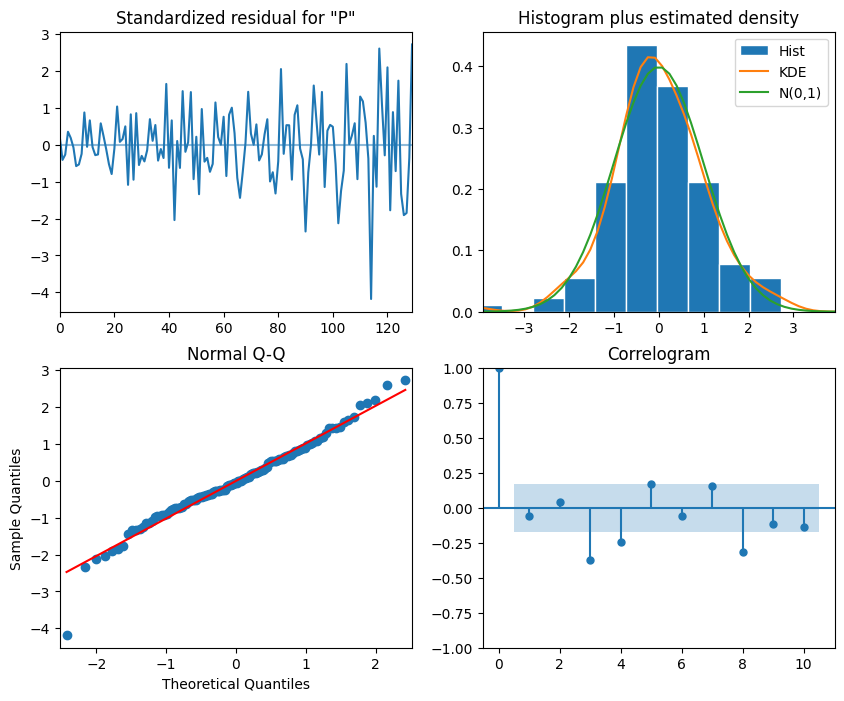

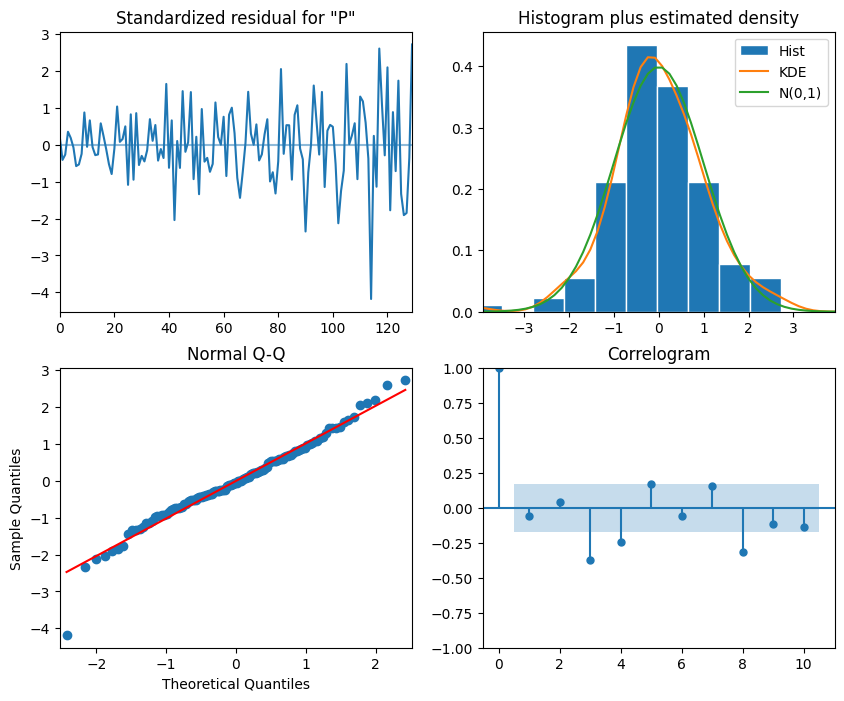

In [34]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [35]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,1.608254,0.204737
2,1.935194,0.379995
3,16.935621,0.000729
4,23.547481,0.000098
5,26.664139,0.000066
6,26.853356,0.000154
7,29.593285,0.000113
8,40.641859,0.000002
9,42.456481,0.000003
10,45.216099,0.000002


SARIMA(2,2,0)(2,0,2)_12  , Ljung-Box test we can reject null hypothesis for lag and for lags 1 to lag 20   
We pick now SARIMA(2,2,3)(1,0,0)_12 

In [36]:
SARIMA_model = SARIMAX(train, order=(2,2,3), seasonal_order=(1,0,0,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  132
Model:             SARIMAX(2, 2, 3)x(1, 0, [], 12)   Log Likelihood                -659.317
Date:                             Thu, 12 Feb 2026   AIC                           1332.635
Time:                                     18:37:20   BIC                           1352.708
Sample:                                          0   HQIC                          1340.791
                                             - 132                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0928      6.499     -0.014      0.989     -12.831      12.646
ar.L2          0.1348      

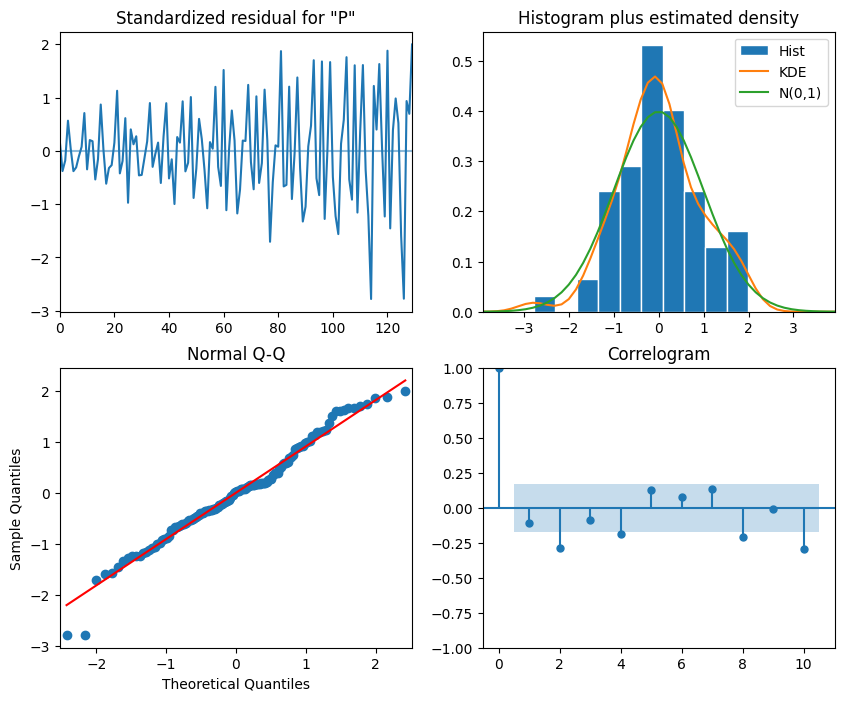

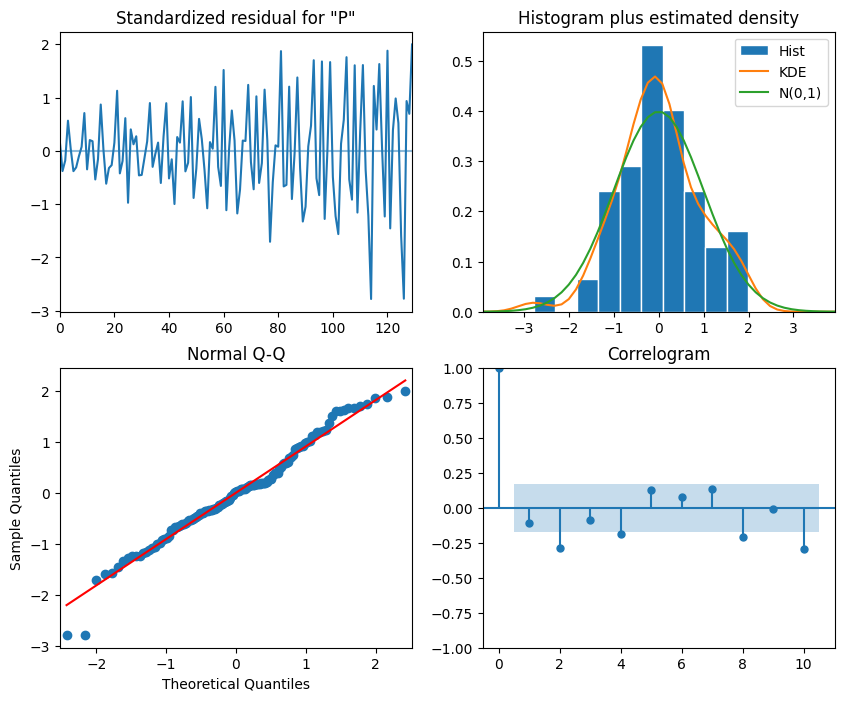

In [37]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))


In [38]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,2.200041,0.138007
2,11.277184,0.003558
3,12.326672,0.006344
4,17.109693,0.001840
5,19.493312,0.001555
6,20.355441,0.002393
7,22.314495,0.002242
8,27.883653,0.000497
9,27.901425,0.000991
10,38.960532,0.000026


SARIMA(2,2,3)(1,0,0)_12 , Ljung-Box test we can reject null hypothesis for lag and for lags 2 to lag 20   
We pick now SARIMA(2,2,3)(3,0,2)_12 

In [39]:
SARIMA_model = SARIMAX(train, order=(2,2,3), seasonal_order=(3,0,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 2, 3)x(3, 0, [1, 2], 12)   Log Likelihood                -667.326
Date:                                 Thu, 12 Feb 2026   AIC                           1356.651
Time:                                         18:37:21   BIC                           1388.194
Sample:                                              0   HQIC                          1369.468
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4763      2.971     -0.160      0.873      -6.299       5

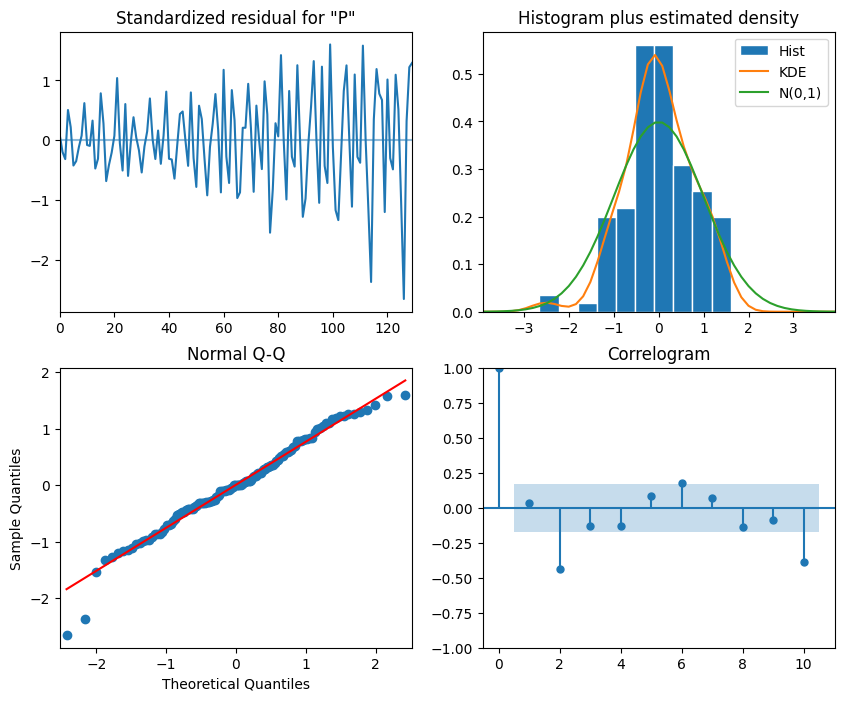

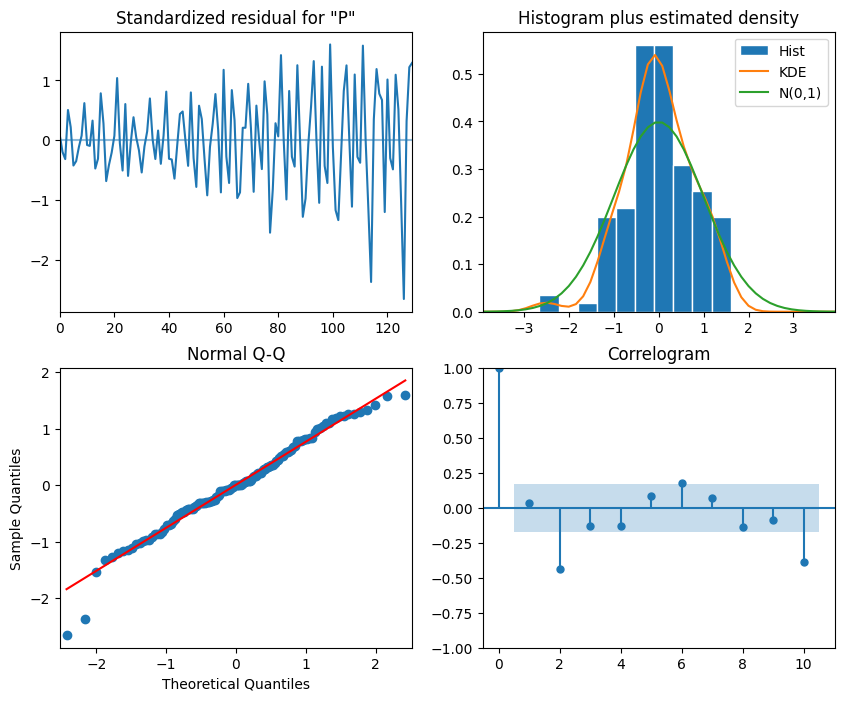

In [40]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [41]:
residuals = SARIMA_model_fit.resid
lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))
lb_dataframe

,lb_stat,lb_pvalue
1,0.000085,9.926506e-01
2,21.679603,1.960352e-05
3,23.802670,2.746521e-05
4,26.377575,2.655386e-05
5,27.421208,4.721788e-05
6,31.732929,1.835795e-05
7,32.138280,3.828711e-05
8,34.671808,3.068076e-05
9,35.630908,4.609224e-05
10,54.631744,3.699745e-08


SARIMA(2,2,3)(3,0,2)_12  , Ljung-Box test we can reject null hypothesis for lag and for lags 2 to lag 20   

We tried 10 models and none capture all the information from the data. Still, let's pick the first one.

*******************************************************************************************
Forecast with model

In [42]:
SARIMA_model = SARIMAX(train, order=(1,2,0), seasonal_order=(3,0,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='nm') # method='powell'
#print(SARIMA_model_fit.summary())

In [43]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test

,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [44]:
# Pg 175

SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,Month,Passengers,naive_seasonal,SARIMA_pred
132,1960-01,417,360,436.844437
133,1960-02,391,342,448.295961
134,1960-03,419,406,506.732580
135,1960-04,461,396,520.791982
136,1960-05,472,420,553.378287
137,1960-06,535,472,591.938342
138,1960-07,622,548,653.681368
139,1960-08,606,559,675.325802
140,1960-09,508,463,648.222803
141,1960-10,461,407,632.136808


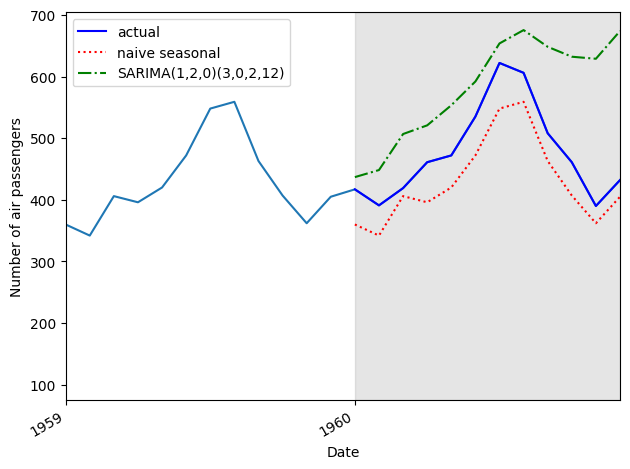

In [45]:
# Figure 8.13 in pg 176

fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(1,2,0)(3,0,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()


In [46]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
#mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

9.987532920823485 23.30615223728206
